# Hexagon coloring experiments (scratchwork)

### Xanadu functions

In [1]:
# Copyright 2019 Xanadu Quantum Technologies Inc.
r"""
Dense subgraph identification
=============================

**Module name:** :mod:`gbsapps.graph.dense_subgraph`

.. currentmodule:: gbsapps.graph.dense_subgraph

The frontend module for users to find dense subgraphs. The :func:`find_dense_subgraph` function
provides approximate solutions to the densest-:math:`k` subgraph problem
:cite:`arrazola2018using`, which is NP-hard. This problem considers a graph :math:`G = (V,
E)` of :math:`N` nodes :math:`V` and a list of edges :math:`E`, and sets the objective of finding a
:math:`k`-vertex subgraph with the greatest density. In this setting, subgraphs :math:`G[S]` are
defined by nodes :math:`S \subset V` and corresponding edges :math:`E_{S} \subseteq E` that
have both endpoints in :math:`S`. The density of a subgraph is given by

.. math:: d(G[S]) = \frac{2 |E_{S}|}{|S|(|S|-1)},

where :math:`|\cdot|` denotes cardinality, and the densest-:math:`k` subgraph problem can be
written
succinctly as

.. math:: {\rm argmax}_{S \in \mathcal{S}_{k}} d(G[S])

with :math:`\mathcal{S}_{k}` the set of all possible :math:`k` node subgraphs. This problem grows
combinatorially with :math:`{N \choose k}` and is NP-hard in the worst case.

The :func:`find_dense_subgraph` function provides access to heuristic algorithms for finding
approximate solutions. At present, random search is the heuristic algorithm provided, accessible
through the :func:`random_search` function. This algorithm proceeds by randomly generating a set
of :math:`k` vertex subgraphs and selecting the densest. Sampling of subgraphs can be achieved
both uniformly at random and also with a quantum sampler programmed to be biased toward
outputting dense subgraphs.

Summary
-------

.. autosummary::
    METHOD_DICT
    find_dense_subgraph
    random_search

Code details
------------
"""
import functools
from typing import Callable, Union, Tuple
import networkx as nx

from gbsapps.graph.graph_sample import dense_subgraph_sampler_gbs, uniform_subgraph_sampler
from gbsapps.graph.functions import to_networkx_graph, graph_type


# pylint: disable=too-many-arguments
#[docs]
def find_dense_subgraph(
    graph: graph_type,
    number_of_nodes: int,
    iterations: int = 1,
    method: Union[str, Callable] = "random-search",
    remote: bool = False,
    backend: str = "gaussian",
) -> Tuple[float, list]:
    """Functionality for finding dense `node-induced subgraphs
    <http://mathworld.wolfram.com/Vertex-InducedSubgraph.html>`__ of a given size.

    The user is able to specify a stochastic algorithm as a method for optimization. Furthermore,
    the form of randomness used (e.g., GBS sampling or uniform sampling) in the stochastic
    algorithm can also be specified by setting a backend sampler. This sampling can be performed
    locally or remotely.

    Methods are set with the ``methods`` argument. The available methods are:

    - ``"random-search"``: a simple random search algorithm where many subgraphs are selected and
      the densest one is chosen (default).

    Backends are set with the ``backend`` argument. They include the quantum backends
    given in :meth:`gbsapps.sample.QUANTUM_BACKENDS` as well as a ``"uniform"`` sampler backend.
    The available backends are:

    - ``"gaussian"``: allowing subgraph samples to be simulated using the Gaussian backend of Strawberry Fields (default)
    - ``"uniform"``: allowing subgraph samples to be generated with a uniform distribution using
      the :func:`~gbsapps.graph.graph_sample.uniform_subgraph_sampler` function

    Args:
        graph (graph_type): the input graph
        number_of_nodes (int): the size of desired dense subgraph
        iterations (int): number of iterations to use in algorithm
        method (str or function): either a string selecting from a range of available methods or a
            customized callable function. Defaults to ``"random-search"``.
        remote (bool): Performs sampling on a remote server if ``True``. Remote sampling is required
            for sampling on hardware and is not available with the ``"uniform"`` backend. If not
            specified, sampling will be performed
            locally.
        backend (str): requested backend for sampling; defaults to the ``"gaussian"`` backend

    Returns:
        (float, list): the density and list of nodes corresponding to the densest subgraph found
    """
    if backend == "uniform":
        sampler = uniform_subgraph_sampler
    else:
        sampler = functools.partial(dense_subgraph_sampler_gbs, remote=remote, backend=backend)

    if not callable(method):
        if method in METHOD_DICT:
            method = METHOD_DICT[method]
        else:
            raise Exception("Optimization method must be callable or a valid string")

    return method(to_networkx_graph(graph), number_of_nodes, sampler, iterations=iterations)



#[docs]
def random_search(
    graph: nx.Graph, number_of_nodes: int, sampler: Callable, iterations: int = 1
) -> Tuple[float, list]:
    """Random search algorithm for finding dense subgraphs of a given size.

    The algorithm proceeds by sampling subgraphs according to the function ``sampler``. The
    sampled subgraphs are of size ``number_of_nodes``. The densest subgraph is then selected
    among all the samples.

    Args:
        graph (nx.Graph): the input graph
        number_of_nodes (int): the size of desired dense subgraph
        sampler (function): a function which returns a given number of samples of subgraphs of a
            given size. Must accept arguments in the form: ``(graph: nx.Graph, sampled_nodes: int,
            samples: int = 1)``.
        iterations (int): number of iterations to use in algorithm

    Returns:
        (float, list): the density and list of nodes corresponding to the densest subgraph found
    """
    output_samples = sampler(graph, number_of_nodes, iterations)

    density_and_samples = [(nx.density(graph.subgraph(s)), s) for s in output_samples]

    return max(density_and_samples)



METHOD_DICT = {"random-search": random_search}
"""Dict[str, func]: Included methods for finding dense subgraphs. The dictionary keys are strings
describing the method, while the dictionary values are callable functions corresponding to the
method."""

'Dict[str, func]: Included methods for finding dense subgraphs. The dictionary keys are strings\ndescribing the method, while the dictionary values are callable functions corresponding to the\nmethod.'

In [2]:
# Copyright 2019 Xanadu Quantum Technologies Inc.
r"""
Graph functions
===============

**Module name:** :mod:`gbsapps.graph.functions`

.. currentmodule:: gbsapps.graph.functions

This module provides some ancillary functions for dealing with graphs. This includes
:func:`is_adjacency` to check if an input matrix is symmetric and :func:`subgraph_adjacency` to
return the adjacency matrix of a subgraph when an input graph and subset of nodes is specified.

Furthermore, the frontend :func:`~gbsapps.graph.dense_subgraph.find_dense_subgraph` function
allows users to input graphs both as a `NumPy <https://www.numpy.org/>`__ array containing the
adjacency matrix and as a `NetworkX <https://networkx.github.io/>`__ ``Graph`` object. The
:func:`to_networkx_graph` function allows both inputs to be processed into a NetworkX Graph for
ease of processing in GBSApps.

Summary
-------

.. autosummary::
    is_adjacency
    subgraph_adjacency
    to_networkx_graph

Code details
------------
"""
from typing import Union

import networkx as nx
import numpy as np

graph_type = Union[nx.Graph, np.ndarray]


#[docs]
def to_networkx_graph(graph: graph_type) -> nx.Graph:
    """Converts input graph into a NetworkX graph.

    Given an input graph of type ``graph_type = Union[nx.Graph, np.ndarray]``, this function
    outputs a NetworkX graph of type ``nx.Graph``. The input ``np.ndarray`` must be an adjacency
    matrix (i.e., satisfy :func:`is_adjacency`) and also real.

    Args:
        graph (graph_type): input graph to be processed

    Returns:
        graph: the NetworkX graph corresponding to the input
    """

    if isinstance(graph, np.ndarray):
        if not is_adjacency(graph) or not np.allclose(graph, graph.conj()):
            raise ValueError("Adjacency matrix must be real and symmetric")

        graph = nx.Graph(graph)

    elif not isinstance(graph, nx.Graph):
        raise TypeError("Graph is not of valid type")

    return graph



#[docs]
def is_adjacency(mat: np.ndarray) -> bool:
    """Checks if input is an adjacency matrix, i.e., symmetric.

    Args:
        mat (array): input matrix to be checked

    Returns:
        bool: returns ``True`` if input array is an adjacency matrix and ``False`` otherwise
    """

    if not isinstance(mat, np.ndarray):
        raise TypeError("Input matrix must be a numpy array")

    dims = mat.shape

    conditions = len(dims) == 2 and dims[0] == dims[1] and dims[0] > 1 and np.allclose(mat, mat.T)

    return conditions



#[docs]
def subgraph_adjacency(graph: graph_type, nodes: list) -> np.ndarray:
    """Give adjacency matrix of a subgraph

    Given a list of nodes selecting a subgraph, this function returns the corresponding adjacency
    matrix.

    Args:
        graph (graph_type): the input graph
        nodes (list): a list of nodes used to select the subgraph

    Returns:
        array: the adjacency matrix of the subgraph
    """
    graph = to_networkx_graph(graph)
    all_nodes = graph.nodes

    if not set(nodes).issubset(all_nodes):
        raise ValueError(
            "Must input a list of subgraph nodes that is contained within the nodes of the input "
            "graph"
        )

    return nx.to_numpy_array(graph.subgraph(nodes))




### Import packages

In [3]:
# useful additional packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

### Define functions for workflow

In [4]:
def density_func(A):
    dens = (np.sum(A)/2) / ((A.shape[0]*(A.shape[0]-1))/2)
    return dens

In [5]:
def find_least_connected(A):
    min_sum = float('inf')
    acc = []
    candidates = []
    for i in range(A.shape[0]):
        acc.append(np.sum(A[i]))
        if np.sum(A[i]) < min_sum:
            min_sum = np.sum(A[i])
    for i in range(A.shape[0]):
        if acc[i] == min_sum:
            candidates.append(i)
    min_element = random.choice(candidates)
    return min_element

In [6]:
def remove_node(A, n, nodes):
    A_new = np.delete(A, n, 1)
    A_new = np.delete(A_new, n, 0)
    nodes_new = np.delete(nodes,n)
    return A_new, nodes_new

In [7]:
def resample(g_old, G):
    equal = True
    while equal:
        _, G_new = find_dense_subgraph(G, 8)
        shared_nodes = 0
        for node in g_old:
            if node in G_new:
                shared_nodes += 1
        if shared_nodes < 2:
            equal = False
            return G_new
        
    
            



def paint(A, colors, nodes):
    available_colors = [1,2,3]
    for i in range(1, len(nodes)-1):
        if colors[nodes[i]] == 0 and colors[nodes[i+1]] == 0 and colors[nodes[i-1]]== 0:
            colors[nodes[i]] = 1
        elif colors[nodes[i]] == colors[nodes[i + 1]] and colors[nodes[i-1]] != colors[nodes[i+1]]:
            temp = available_colors.copy()
            temp.remove(colors[nodes[i+1]])
            temp.remove(colors[nodes[i-1]])
            colors[nodes[i]] = random.choice(temp)
        elif colors[nodes[i]] == colors[nodes[i - 1]] and colors[nodes[i+1]] != colors[nodes[i-1]]:
            temp = available_colors.copy()
            temp.remove(colors[nodes[i+1]])
            temp.remove(colors[nodes[i-1]])
            colors[nodes[i]] = random.choice(temp)
    if colors[nodes[0]] == colors[nodes[-1]] and colors[nodes[-1]] != colors[nodes[1]]:
        temp = available_colors.copy()
        temp.remove(colors[nodes[-1]])
        temp.remove(colors[nodes[1]])
        colors[nodes[0]] = random.choice(temp)
    elif colors[nodes[0]] == colors[nodes[-1]]:
        temp = available_colors.copy()
        temp.remove(colors[nodes[-1]])
        colors[nodes[0]] = random.choice(temp)
        
    return colors




def paint_old(A, colors, nodes):
    totalpaint = colors[nodes[0]] + colors[nodes[1]] + colors[nodes[2]]
    if totalpaint == 0:
        colors[nodes[0]] = 1
        colors[nodes[1]] = 2
        colors[nodes[2]] = 3
    elif totalpaint > 0 and totalpaint < 6:
        if colors[nodes[0]] == 0:
            colors[nodes[0]] = 6 - totalpaint
        elif colors[nodes[1]] == 0:
            colors[nodes[1]] = 6 - totalpaint
        elif colors[nodes[2]] == 0:
            colors[nodes[2]] = 6 - totalpaint
    return colors





def paint2(A, colors, nodes):
    available_colors = [1, 2]
    v = random.choice([0, 1, 2])
    for j in range(0,4):
        if v == 0: 
            if colors[nodes[v]] == 0:
                if colors[nodes[v+1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v+1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        if v == 1:
            if colors[nodes[v]] == 0:
                if colors[nodes[v+1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v+1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        if v == 2:
            if colors[nodes[v]] == 0:
                if colors[nodes[v-1]] == 0:
                    colors[nodes[v]] = random.choice([1,2])
                else:
                    if colors[nodes[v-1]] == 1:
                        colors[nodes[v]] = 2
                    else:
                        colors[nodes[v]] = 1
        return colors
                    
            

            
            
def lf(A, nodes,colors):
    sums = []
    for i in range(len(A)):
        sums.append((np.sum(A[i]), i))
    sums.sort(key=lambda tup: tup[0], reverse=True)
    
    colors = np.zeros(len(nodes))
    colors[0] = 1
    for i in range(1, len(sums)):
        maximum = 0
        for j in range(0,i):
            if A[sums[i][1]][sums[j][1]] != 0:
                if colors[sums[j][1]] > maximum:
                    maximum = colors[sums[j][1]] + 1
        colors[i] = maximum
    return colors
        

                

In [8]:
def colorcheck(colors):
    everythingcolored = True
    i = 0
    while everythingcolored and i < len(colors):
        everythingcolored = colors[i] != 0
        i += 1
    return everythingcolored

In [9]:
def shrink(dens, A, nodes,colors):
    while density_func(A) < dens and len(A)>2:
        least_node = find_least_connected(A)
        A, nodes = remove_node(A, least_node, nodes)
    if len(nodes) > 2:
        colors = lf(A, nodes)
        return colors
    else:
        return colors

### Draw graph

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.


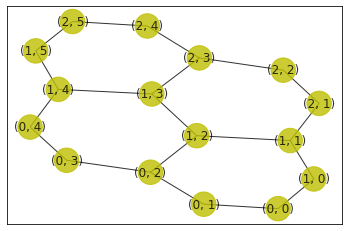

In [13]:
'''
G = nx.Graph()
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 2), (13, 0), (9, 14), (15, 6)]
nodes = list(range(15))
G.add_edges_from(edges)
G.add_nodes_from(nodes)
'''



g = nx.hexagonal_lattice_graph(2, 2)

'''
G = nx.Graph()
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 4), (4, 5), (5, 6), (6, 7), (7, 4), (5, 7), (4, 6), (1, 5), (6, 2), (7, 3), (5, 2), (4, 3), (6, 1), (7, 0)]
nodes = list(range(8))
G.add_edges_from(edges)
G.add_nodes_from(nodes)
'''
colors = ['y' for node in g.nodes()]

pos = nx.spring_layout(g)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(g, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

### Attempt coloring

In [ ]:
colors = np.zeros(len(G.nodes))
dens = 0.4
everythingcolored = False
while not everythingcolored:
    _, G_new = find_dense_subgraph(G, 5)
    #resample(G_new, G)
    A = subgraph_adjacency(G, G_new)
    colors = shrink(dens, A, G_new, colors)
    print(colors)
    everythingcolored = colorcheck(colors)

In [ ]:
print(colors)

In [ ]:
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)